In [2]:
# Local setup (non-Kaggle)
from pathlib import Path
import numpy as np
import pandas as pd
import os

PROJECT_ROOT = Path().resolve()
print("Project root:", PROJECT_ROOT)


Project root: /workspace


## 0. Setup and paths

In [14]:
import os
import glob
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 1. Verify paths in notebook  

In [4]:
from pathlib import Path

IMAGE_ROOTS = [
    Path("./data/soil_images/Orignal-Dataset"),
    Path("./data/soil_images/CyAUG-Dataset"),
]
for root in IMAGE_ROOTS:
    print(root, "exists:", root.exists())


data/soil_images/Orignal-Dataset exists: True
data/soil_images/CyAUG-Dataset exists: True


## 2. Load the original dataset folder

In [5]:
from pathlib import Path

IMAGE_ROOTS = [
    Path("./data/soil_images/Orignal-Dataset"),
    Path("./data/soil_images/CyAUG-Dataset"),
]
print("Image roots:", IMAGE_ROOTS)
for root in IMAGE_ROOTS:
    if not root.exists():
        print("Warning: missing", root)
    else:
        print(root.name, "classes:", sorted([p.name for p in root.iterdir() if p.is_dir()]))


Image roots: [PosixPath('data/soil_images/Orignal-Dataset'), PosixPath('data/soil_images/CyAUG-Dataset')]
Orignal-Dataset classes: ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']
CyAUG-Dataset classes: ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']


## 3. Create train / val / test splits (stratified)

In [6]:
from pathlib import Path

# Build a dataframe with filepaths and class labels from both roots
image_paths = []
for root in IMAGE_ROOTS:
    image_paths.extend(root.glob("*/*"))

if not image_paths:
    raise FileNotFoundError(f"No images found under {IMAGE_ROOTS}. Check paths or dataset download.")

records = []
for path in image_paths:
    label = path.parent.name  # folder name = soil type
    source = path.parent.parent.name
    records.append((str(path), label, source))

df = pd.DataFrame(records, columns=["filepath", "label", "source"])
print(df.head(), len(df))
print("Label counts:\n", df["label"].value_counts())
print("Source counts:\n", df["source"].value_counts())


                                            filepath          label  \
0  data/soil_images/Orignal-Dataset/Laterite_Soil...  Laterite_Soil   
1  data/soil_images/Orignal-Dataset/Laterite_Soil...  Laterite_Soil   
2  data/soil_images/Orignal-Dataset/Laterite_Soil...  Laterite_Soil   
3  data/soil_images/Orignal-Dataset/Laterite_Soil...  Laterite_Soil   
4  data/soil_images/Orignal-Dataset/Laterite_Soil...  Laterite_Soil   

            source  
0  Orignal-Dataset  
1  Orignal-Dataset  
2  Orignal-Dataset  
3  Orignal-Dataset  
4  Orignal-Dataset   6286
Label counts:
 label
Yellow_Soil      1470
Black_Soil       1428
Red_Soil         1235
Alluvial_Soil     745
Arid_Soil         568
Laterite_Soil     438
Mountain_Soil     402
Name: count, dtype: int64
Source counts:
 source
CyAUG-Dataset      5097
Orignal-Dataset    1189
Name: count, dtype: int64


In [7]:
RANDOM_STATE = 42
TEST_SIZE = 0.20   # 20% test
VAL_SIZE = 0.10    # 10% val (of the whole)

# 1.2. First: split off TEST from (train+val)
train_val_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    stratify=df["label"],
    random_state=RANDOM_STATE,
)

# 1.3. Then split train_val into TRAIN and VAL
val_rel_size = VAL_SIZE / (1 - TEST_SIZE)  # fraction of train_val that becomes val

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_rel_size,
    stratify=train_val_df["label"],
    random_state=RANDOM_STATE,
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print(train_df["label"].value_counts())
print(val_df["label"].value_counts())
print(test_df["label"].value_counts())

Train: 4399 Val: 629 Test: 1258
label
Yellow_Soil      1029
Black_Soil        999
Red_Soil          864
Alluvial_Soil     522
Arid_Soil         397
Laterite_Soil     306
Mountain_Soil     282
Name: count, dtype: int64
label
Yellow_Soil      147
Black_Soil       143
Red_Soil         124
Alluvial_Soil     74
Arid_Soil         57
Laterite_Soil     44
Mountain_Soil     40
Name: count, dtype: int64
label
Yellow_Soil      294
Black_Soil       286
Red_Soil         247
Alluvial_Soil    149
Arid_Soil        114
Laterite_Soil     88
Mountain_Soil     80
Name: count, dtype: int64


In [8]:
class_names = sorted(df["label"].unique())
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}
num_classes = len(class_names)

print("Class mapping:", class_to_idx)

Class mapping: {'Alluvial_Soil': 0, 'Arid_Soil': 1, 'Black_Soil': 2, 'Laterite_Soil': 3, 'Mountain_Soil': 4, 'Red_Soil': 5, 'Yellow_Soil': 6}


## 3. PyTorch Dataset & DataLoaders

In [9]:
from torchvision import transforms

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [10]:
from torch.utils.data import Dataset
from PIL import Image

class SoilDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        label_str = row["label"]
        label = class_to_idx[label_str]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
train_dataset = SoilDataset(train_df, transform=train_transform)
val_dataset   = SoilDataset(val_df,   transform=val_test_transform)
test_dataset  = SoilDataset(test_df,  transform=val_test_transform)

NUM_WORKERS = 0  # adjust as needed

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

len(train_loader), len(val_loader), len(test_loader)

(138, 20, 40)

In [15]:
# Optional: torchvision ImageFolder view of the combined roots
soil_train_dataset = ImageFolder(root=IMAGE_ROOTS[0], transform=train_transform)
soil_train_dataset.classes

['Alluvial_Soil',
 'Arid_Soil',
 'Black_Soil',
 'Laterite_Soil',
 'Mountain_Soil',
 'Red_Soil',
 'Yellow_Soil']

In [16]:
soil_train_dataset.classes

['Alluvial_Soil',
 'Arid_Soil',
 'Black_Soil',
 'Laterite_Soil',
 'Mountain_Soil',
 'Red_Soil',
 'Yellow_Soil']

## 4. Define CNN model

In [17]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, num_classes)
resnet50 = resnet50.to(device)

rs_criterion = nn.CrossEntropyLoss()
rs_optimizer = optim.Adam(resnet50.parameters(), lr=1e-3)

## 5. Training loop with validation & best model saving

In [19]:
from copy import deepcopy
import time
from pathlib import Path

CHECKPOINT_DIR = Path("./artifacts")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = CHECKPOINT_DIR / "best_resnet_soil.pth"


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_model_wts = deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        start = time.time()
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # ----- TRAIN -----
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double().item() / len(train_loader.dataset)

        # ----- VALIDATION -----
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double().item() / len(val_loader.dataset)

        elapsed = time.time() - start
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f} (Time: {elapsed:.1f}s)")

        # Save best weights
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            torch.save(best_model_wts, CKPT_PATH)
            print("  --> Best model updated and saved to", CKPT_PATH)

    print(f"\nBest val accuracy: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


In [20]:
# Load trained model if available, otherwise run training
if CKPT_PATH.exists():
    resnet50.load_state_dict(torch.load(CKPT_PATH, map_location=device))
    print("Loaded ResNet50 checkpoint from", CKPT_PATH)
else:
    resnet50 = train_model(resnet50, train_loader, val_loader, rs_criterion, rs_optimizer, num_epochs=100)

Loaded ResNet50 checkpoint from artifacts/best_resnet_soil.pth


## 5. Evaluate on unseen test set

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

resnet50.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = resnet50(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Classification report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
cm

Classification report:

               precision    recall  f1-score   support

Alluvial_Soil       0.98      0.40      0.57       149
    Arid_Soil       0.62      0.97      0.76       114
   Black_Soil       0.99      0.98      0.99       286
Laterite_Soil       0.76      0.91      0.83        88
Mountain_Soil       0.75      1.00      0.86        80
     Red_Soil       0.98      0.98      0.98       247
  Yellow_Soil       0.95      0.90      0.92       294

     accuracy                           0.89      1258
    macro avg       0.86      0.88      0.84      1258
 weighted avg       0.91      0.89      0.88      1258



array([[ 60,  42,   0,  25,   7,   0,  15],
       [  0, 111,   1,   0,   2,   0,   0],
       [  0,   0, 281,   0,   5,   0,   0],
       [  0,   1,   1,  80,   2,   4,   0],
       [  0,   0,   0,   0,  80,   0,   0],
       [  0,   6,   0,   0,   0, 241,   0],
       [  1,  18,   0,   0,  11,   0, 264]])

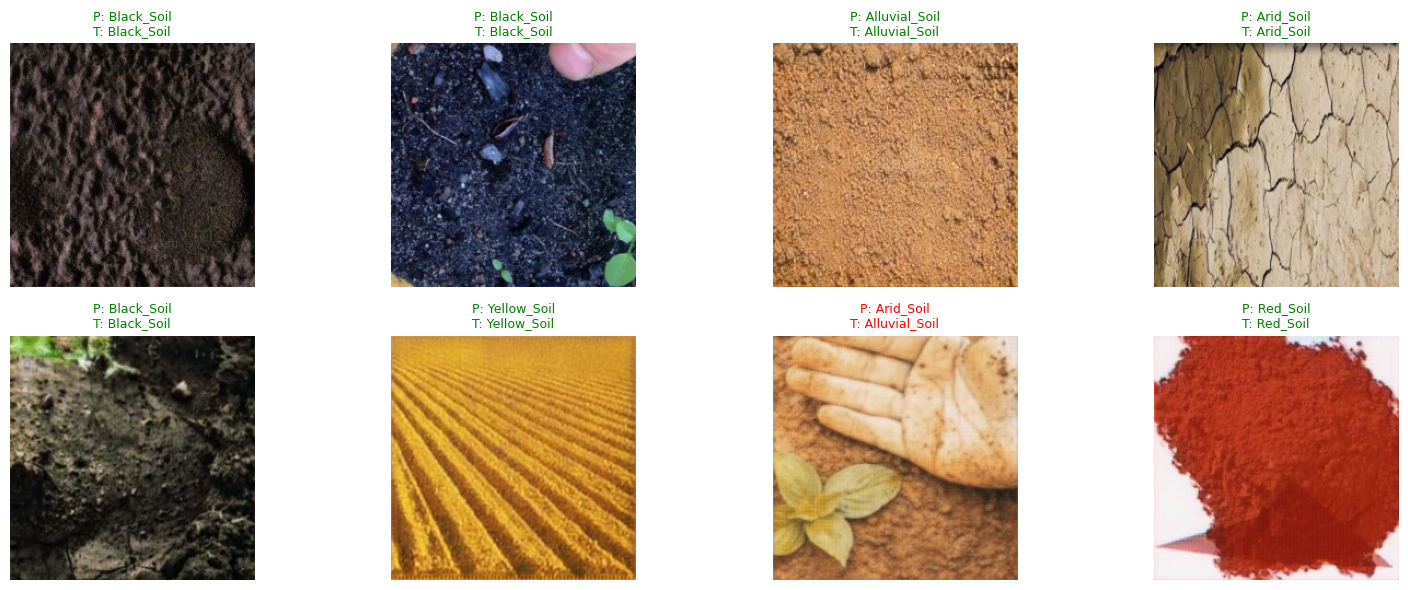

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# mean/std used in your Normalize (ImageNet here)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def unnormalize(img_tensor):
    """
    img_tensor: CxHxW tensor (normalized)
    returns: HxWxC numpy image in [0,1]
    """
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = IMAGENET_STD * img + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

# Get one batch from test loader
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = resnet50(images)
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

# Choose 8 random images from the batch
indices = random.sample(range(len(images)), min(8, len(images)))  # list of random indices
N = len(indices)  # number of images actually chosen
fig, axes = plt.subplots(2, N // 2, figsize=(16, 6))
axes = axes.flatten()

# Loop over indices and axes together
for j, i in enumerate(indices):
    img = unnormalize(images[i])
    true_label = idx_to_class[labels[i].item()]
    pred_label = idx_to_class[preds[i].item()]

    ax = axes[j]  # use j here, not i
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"P: {pred_label}\nT: {true_label}",
                 color=("green" if pred_label == true_label else "red"),
                 fontsize=9)

plt.tight_layout()
plt.show()

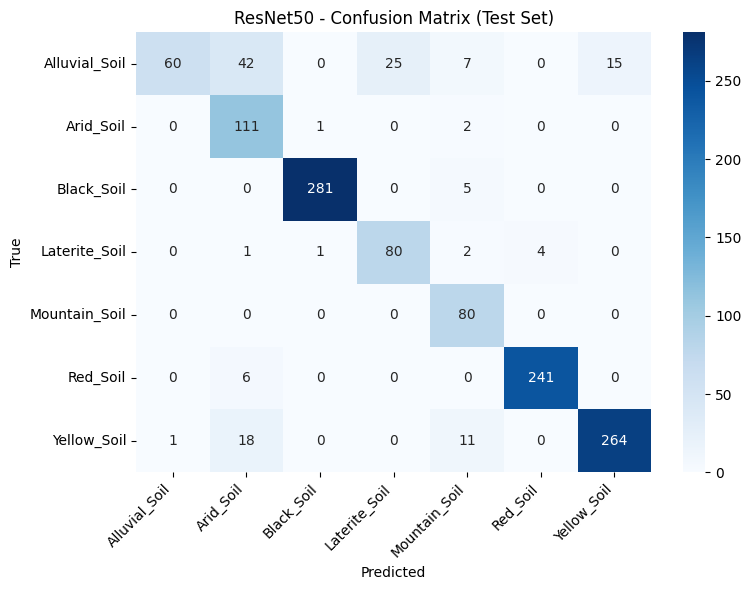

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # if seaborn not installed: `pip install seaborn`

all_labels = []
all_preds = []

resnet50.eval()
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        lbls = lbls.to(device)

        outputs = resnet50(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(lbls.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet50 - Confusion Matrix (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Crop Recommendation Module Using an XGBoost

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [28]:
# 1. Load the Crop Recommendation Dataset
df = pd.read_csv('./data/tabular/d1.csv')
print("First few rows of the dataset:")
print(df.head())
print("Dataset info:")
print(df.info())

First few rows of the dataset:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), obj

In [29]:
# 2. Preprocessing:
#    - Our target is the 'label' column (the recommended crop).
#    - The original features include: N, P, K, temperature, humidity, ph, rainfall.
#    - We simulate a soil type (which in a deployed system comes from the image classification module).

np.random.seed(42)
df['soil_type'] = np.random.randint(0, 4, size=len(df))
print("\nValue counts for simulated soil_type:")
print(df['soil_type'].value_counts())

# One-hot encode the soil_type column
soil_type_dummies = pd.get_dummies(df['soil_type'], prefix='soil')
df = pd.concat([df.drop('soil_type', axis=1), soil_type_dummies], axis=1)


Value counts for simulated soil_type:
soil_type
0    578
1    545
2    543
3    534
Name: count, dtype: int64


In [30]:
# 3. Separate features and target.
#    The original features: N, P, K, temperature, humidity, ph, rainfall
#    Plus the one-hot encoded soil type features.
X = df.drop('label', axis=1).values  # Feature matrix
y = df['label'].values               # Crop labels

# Convert crop labels (which are strings) into integer labels using LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nUnique crop labels:", le.classes_)


Unique crop labels: ['apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans'
 'mungbean' 'muskmelon' 'orange' 'papaya' 'pigeonpeas' 'pomegranate'
 'rice' 'watermelon']


In [31]:
# 4. Standardize the numerical features.
#    We assume that the first 7 columns are numerical (N, P, K, temperature, humidity, ph, rainfall),
#    and the remaining columns are the one-hot encoded soil type.
scaler = StandardScaler()
X_num = scaler.fit_transform(X[:, :7])
X_cat = X[:, 7:]  # one-hot soil type columns

# Concatenate numerical and categorical features
X_final = np.concatenate([X_num, X_cat], axis=1)

# Convert final feature matrix to float32 to avoid type conversion errors
X_final = X_final.astype(np.float32)
print("\nShape of final feature matrix:", X_final.shape)


Shape of final feature matrix: (2200, 11)


In [32]:
# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42)

In [33]:
# 6. Create a custom PyTorch Dataset for the tabular data
class CropDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CropDataset(X_train, y_train)
test_dataset = CropDataset(X_test, y_test)

# Create DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create and train the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate accuracy
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Test Accuracy: {:.2f}%".format(acc_xgb * 100))

/opt/conda/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [17:47:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Accuracy: 98.64%


## 7. Pipeline for the Crop Recommender System

----- Test: Strongly Acidic Scenario -----
Predicted Soil Type from image: Black_Soil
Recommended Crop: Not suitable for any crop
For the given input (pH ~3.7), recommended crop: Not suitable for any crop

----- Test: Neutral pH Scenario -----
Predicted Soil Type from image: Black_Soil
Recommended Crop: Maize
For the given input (pH ~6.5), recommended crop: Maize


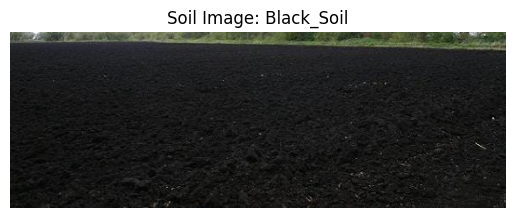

In [36]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# Helper Functions
# ---------------------------

def predict_soil_type(image_path, model, transform):
    """
    Predict the soil type from an image.
    Returns the integer label.
    """
    model.eval()  # Set the model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def one_hot_encode(label, num_classes):
    """
    Convert an integer label into a one-hot encoded vector.
    """
    return np.eye(num_classes)[label]

def rule_based_crop_recommendation(soil_numerical_values, soil_label):
    """
    Given numerical soil measurements and a soil type label,
    apply threshold-based rules to recommend a crop.
    
    Expected order of soil_numerical_values: [N, P, K, temperature, humidity, pH, rainfall]
    """
    # Extract values
    N = soil_numerical_values[0, 0]
    P = soil_numerical_values[0, 1]
    K = soil_numerical_values[0, 2]
    pH = soil_numerical_values[0, 5]
    
    # Rule 1: pH thresholds
    if pH < 4.0 or pH > 7.5:
        return "Not suitable for any crop"
    
    # Rule 2: Nutrient thresholds (set arbitrary thresholds; adjust based on domain knowledge)
    # For example, require minimum values: N>=50, P>=20, K>=20 for a viable crop.
    if N < 50 or P < 20 or K < 20:
        return "Nutrients deficient - not suitable for any crop"
    
    # Rule 3: Based on soil type.
    # Assume soil_train_dataset.classes returns a list like: ["Alluvial soil", "Black Soil", "Clay soil", "Red soil"]
    soil_type = soil_train_dataset.classes[soil_label]
    
    if soil_type == "Alluvial_Soil":
        return "Rice"       # For example, Alluvial soils are ideal for rice.
    elif soil_type == "Black_Soil":
        return "Maize"      # Black soils are often used for maize.
    elif soil_type == "Clay_Soil":
        return "Wheat"      # Clay soils can be used for wheat.
    elif soil_type == "Red_Soil":
        return "Vegetables" # Red soils may be better for vegetable crops.
    else:
        return "Crop recommendation unclear"

# ---------------------------
# Integrated Pipeline Function
# ---------------------------

def integrated_rule_based_recommendation(soil_image_path, soil_numerical_values):
    """
    End-to-end pipeline that:
      1. Takes a soil image and numerical measurements.
      2. Predicts the soil type using a soil classification model.
      3. Applies rule-based thresholds on pH and nutrients.
      4. Recommends a crop.
    """
    # Step A: Soil Classification
    soil_label = predict_soil_type(soil_image_path, resnet50, val_test_transform)
    soil_type_name = soil_train_dataset.classes[soil_label]
    print("Predicted Soil Type from image:", soil_type_name)
    
    # (Optional) If you wish to one-hot encode the soil type for other pipelines,
    # you can do that. For our rule-based decision, we just need the label.
    
    # Step B: Use the raw numerical features (assumed to be in order: N, P, K, temperature, humidity, pH, rainfall)
    # Here we assume the user inputs raw values (without scaling) since thresholds are defined on raw values.
    # (If your training data used scaled values, you might need to inverse-transform or define thresholds on scaled values.)
    
    # Step C: Apply rule-based logic to recommend a crop
    recommended_crop = rule_based_crop_recommendation(soil_numerical_values, soil_label)
    print("Recommended Crop:", recommended_crop)
    return recommended_crop

# ---------------------------
# Example Usage
# ---------------------------

# Example 1: Strongly acidic soil scenario
# Numerical measurements: [N, P, K, temperature, humidity, pH, rainfall]
# For instance, pH=3.7 (strongly acidic) even if other nutrient values are adequate.
soil_numerical_values_acidic = np.array([[90, 40, 40, 20, 80, 3.7, 200]])  # pH is 3.7
soil_image_path = soil_image_path = test_df.sample(1)["filepath"].iloc[0]

print("----- Test: Strongly Acidic Scenario -----")
recommended_crop_acidic = integrated_rule_based_recommendation(soil_image_path, soil_numerical_values_acidic)
print("For the given input (pH ~3.7), recommended crop:", recommended_crop_acidic)

# Example 2: Neutral pH scenario with sufficient nutrients
soil_numerical_values_neutral = np.array([[90, 40, 40, 20, 80, 6.5, 200]])  # pH is 6.5, within acceptable range
print("\n----- Test: Neutral pH Scenario -----")
recommended_crop_neutral = integrated_rule_based_recommendation(soil_image_path, soil_numerical_values_neutral)
print("For the given input (pH ~6.5), recommended crop:", recommended_crop_neutral)

# (Optional) Visualize the sample soil image for reference
img = Image.open(soil_image_path)
plt.imshow(img)
plt.title("Soil Image: " + soil_train_dataset.classes[predict_soil_type(soil_image_path, resnet50, val_test_transform)])
plt.axis("off")
plt.show()

----- Running Crop Recommendation Tests -----

Test Case: Strongly acidic (pH=3.7) with adequate nutrients, Alluvial soil
Predicted Soil Type: Laterite_Soil
Recommended Crop(s): ['Not suitable for any crop']

Test Case: Highly alkaline (pH=8.0) with adequate nutrients, Black Soil
Predicted Soil Type: Mountain_Soil
Recommended Crop(s): ['Not suitable for any crop']

Test Case: Nutrient deficient (N=40) at neutral pH (6.5), Clay soil
Predicted Soil Type: Arid_Soil
Recommended Crop(s): ['Nutrients deficient - not suitable for any crop']

Test Case: Optimal conditions for Alluvial soil with high nutrients
Predicted Soil Type: Red_Soil
Recommended Crop(s): ['Vegetables', 'Pulses']

Test Case: Optimal conditions for Black Soil with high nutrients
Predicted Soil Type: Red_Soil
Recommended Crop(s): ['Vegetables', 'Pulses']

Test Case: Optimal conditions for Clay soil with high nutrients
Predicted Soil Type: Arid_Soil
Recommended Crop(s): ['Crop recommendation unclear']

Test Case: Optimal cond

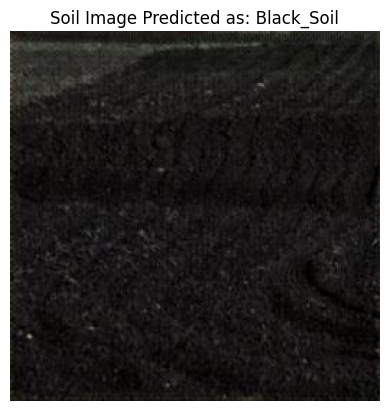

In [37]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# Updated Rule-Based Crop Recommendation Function
# ---------------------------
def rule_based_crop_recommendation(soil_numerical_values, soil_label):
    """
    Given numerical soil measurements (order: [N, P, K, temperature, humidity, pH, rainfall])
    and a soil type label (an integer index), return a list of recommended crops based on thresholds.
    """
    # Extract key values
    N = soil_numerical_values[0, 0]
    P = soil_numerical_values[0, 1]
    K = soil_numerical_values[0, 2]
    pH = soil_numerical_values[0, 5]
    
    # Rule for pH: if too acidic (<4.0) or too alkaline (>7.5), no crop is suitable.
    if pH < 4.0 or pH > 7.5:
        return ["Not suitable for any crop"]
    
    # Rule for nutrient deficiency: if any key nutrient is too low.
    if N < 50 or P < 20 or K < 20:
        return ["Nutrients deficient - not suitable for any crop"]
    
    # Get soil type name from the soil classification dataset
    soil_type = soil_train_dataset.classes[soil_label]
    recommendations = []
    
    # For demonstration, we add multiple recommendations if nutrient levels are very high.
    if soil_type == "Alluvial_Soil":
        # Moderate conditions: recommend Rice
        recommendations = ["Rice"]
        # If very high nutrients, also recommend Sugarcane (example)
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Sugarcane")
    elif soil_type == "Black_Soil":
        recommendations = ["Maize"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Cotton")
    elif soil_type == "Clay_Soil":
        recommendations = ["Wheat"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Barley")
    elif soil_type == "Red_Soil":
        recommendations = ["Vegetables"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Pulses")
    else:
        recommendations = ["Crop recommendation unclear"]
    
    return recommendations

# ---------------------------
# Updated Integrated Pipeline (with override option)
# ---------------------------
def integrated_rule_based_recommendation(soil_image_path, soil_numerical_values, override_soil_label=None):
    """
    End-to-end pipeline that:
      1. Takes a soil image and numerical measurements.
      2. Predicts the soil type using the soil classification model,
         or uses override_soil_label if provided.
      3. Applies rule-based thresholds on pH and key nutrients.
      4. Returns a list of recommended crops.
    """
    # If override_soil_label is provided, use it; otherwise predict from image.
    if override_soil_label is None:
        soil_label = predict_soil_type(soil_image_path, resnet50, val_test_transform)
    else:
        soil_label = override_soil_label
    
    soil_type_name = soil_train_dataset.classes[soil_label]
    print("Predicted Soil Type:", soil_type_name)
    
    # For rule-based decisions, we assume the numerical features are in raw (unscaled) form.
    # (Adjust thresholds accordingly if you use scaled values.)
    recommended_crops = rule_based_crop_recommendation(soil_numerical_values, soil_label)
    print("Recommended Crop(s):", recommended_crops)
    return recommended_crops

# ---------------------------
# Test Cases
# ---------------------------
# Define a list of test scenarios.
# Each test case is a dictionary with:
# - 'name': a label for the test case.
# - 'numerical': a NumPy array of shape (1,7) representing [N, P, K, temperature, humidity, pH, rainfall].
# - 'override_soil_label': an integer (0,1,2,3) representing a soil type, or None to use the image.
test_cases = [
    {
        "name": "Strongly acidic (pH=3.7) with adequate nutrients, Alluvial soil",
        "numerical": np.array([[90, 40, 40, 20, 80, 3.7, 200]]),
        "override_soil_label": None
    },
    {
        "name": "Highly alkaline (pH=8.0) with adequate nutrients, Black Soil",
        "numerical": np.array([[90, 40, 40, 25, 70, 8.0, 150]]),
        "override_soil_label": None
    },
    {
        "name": "Nutrient deficient (N=40) at neutral pH (6.5), Clay soil",
        "numerical": np.array([[40, 40, 40, 20, 80, 6.5, 200]]),
        "override_soil_label": None
    },
    {
        "name": "Optimal conditions for Alluvial soil with high nutrients",
        "numerical": np.array([[120, 60, 60, 22, 75, 6.5, 180]]),
        "override_soil_label": None
    },
    {
        "name": "Optimal conditions for Black Soil with high nutrients",
        "numerical": np.array([[120, 60, 60, 23, 80, 6.5, 170]]),
        "override_soil_label": None
    },
    {
        "name": "Optimal conditions for Clay soil with high nutrients",
        "numerical": np.array([[120, 60, 60, 20, 85, 6.5, 160]]),
        "override_soil_label": None
    },
    {
        "name": "Optimal conditions for Red soil with high nutrients",
        "numerical": np.array([[120, 60, 60, 21, 80, 6.5, 190]]),
        "override_soil_label": None
    }
]

# Run the tests
print("----- Running Crop Recommendation Tests -----")
for case in test_cases:
    print("\nTest Case:", case["name"])
    sample_soil_image = test_df.sample(1)['filepath'].iloc[0]
    # Call the integrated pipeline with the test case values.
    integrated_rule_based_recommendation(sample_soil_image, case["numerical"], override_soil_label=case["override_soil_label"])

# ---------------------------
# (Optional) Visualize one sample image with its predicted soil type from a model (if not overridden)
predicted_soil = predict_soil_type(sample_soil_image, resnet50, val_test_transform)
soil_name = soil_train_dataset.classes[predicted_soil]
img = Image.open(sample_soil_image)
plt.imshow(img)
plt.title("Soil Image Predicted as: " + soil_name)
plt.axis("off")
plt.show()

----- Running Crop Recommendation Tests (Using Image Prediction) -----

Test Case: Strongly acidic (pH=3.7) with adequate nutrients, expected: Not suitable
Predicted Soil Type from image: Yellow_Soil
Recommended Crop(s): ['Not suitable for any crop']

Test Case: Highly alkaline (pH=8.0) with adequate nutrients, expected: Not suitable
Predicted Soil Type from image: Yellow_Soil
Recommended Crop(s): ['Not suitable for any crop']

Test Case: Nutrient deficient (N=40) at neutral pH (6.5), expected: Nutrients deficient
Predicted Soil Type from image: Yellow_Soil
Recommended Crop(s): ['Nutrients deficient - not suitable for any crop']

Test Case: Optimal conditions for Alluvial soil with high nutrients, expected: Rice and Sugarcane
Predicted Soil Type from image: Yellow_Soil
Recommended Crop(s): ['Crop recommendation unclear']

Test Case: Optimal conditions for Black Soil with high nutrients, expected: Maize and Cotton
Predicted Soil Type from image: Yellow_Soil
Recommended Crop(s): ['Crop r

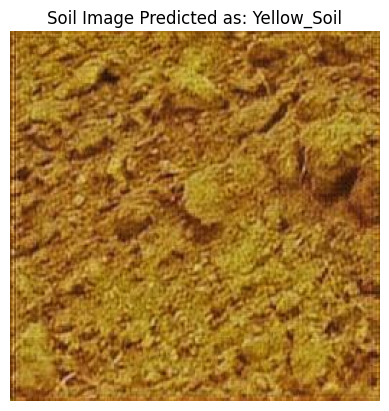

In [38]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# Helper Functions
# ---------------------------

def predict_soil_type(image_path, model, transform):
    """
    Given an image path, predict the soil type using the provided soil classification model.
    Returns the predicted integer label.
    """
    model.eval()  # Set the model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def one_hot_encode(label, num_classes):
    """
    Converts an integer label into a one-hot encoded vector of length num_classes.
    """
    return np.eye(num_classes)[label]

def rule_based_crop_recommendation(soil_numerical_values, soil_label):
    """
    Given numerical soil measurements (order: [N, P, K, temperature, humidity, pH, rainfall])
    and a soil type label (an integer index), return a list of recommended crops based on thresholds.
    """
    # Extract key values
    N = soil_numerical_values[0, 0]
    P = soil_numerical_values[0, 1]
    K = soil_numerical_values[0, 2]
    pH = soil_numerical_values[0, 5]
    
    # Rule for pH: if too acidic (<4.0) or too alkaline (>7.5), no crop is suitable.
    if pH < 4.0 or pH > 7.5:
        return ["Not suitable for any crop"]
    
    # Rule for nutrient deficiency: if any key nutrient is too low.
    if N < 50 or P < 20 or K < 20:
        return ["Nutrients deficient - not suitable for any crop"]
    
    # Get soil type name from the soil classification dataset
    soil_type = soil_train_dataset.classes[soil_label]
    recommendations = []
    
    # For demonstration, add multiple recommendations if nutrient levels are very high.
    if soil_type == "Alluvial_Soil":
        recommendations = ["Rice"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Sugarcane")
    elif soil_type == "Black_Soil":
        recommendations = ["Maize"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Cotton")
    elif soil_type == "Clay_Soil":
        recommendations = ["Wheat"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Barley")
    elif soil_type == "Red_Soil":
        recommendations = ["Vegetables"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Pulses")
    else:
        recommendations = ["Crop recommendation unclear"]
    
    return recommendations

# ---------------------------
# Integrated Pipeline A Function (No override)
# ---------------------------

def integrated_crop_recommendation(soil_image_path, soil_numerical_values):
    """
    Integrated pipeline that:
      1. Takes a soil image and numerical measurements.
      2. Predicts the soil type using the soil classification model.
      3. One-hot encodes the predicted soil type.
      4. Applies the rule-based crop recommendation using numerical features.
    
    Parameters:
      soil_image_path (str): Path to the soil image.
      soil_numerical_values (np.array): Array of shape (1,7) with [N, P, K, temperature, humidity, pH, rainfall].
    
    Returns:
      recommended_crops (list): A list of recommended crops.
    """
    # Step 1: Predict soil type from the image
    soil_label = predict_soil_type(soil_image_path, resnet50, val_test_transform)
    soil_type_name = soil_train_dataset.classes[soil_label]
    print("Predicted Soil Type from image:", soil_type_name)
    
    # Step 2: One-hot encode the soil type (if needed for other pipelines)
    num_soil_classes = len(soil_train_dataset.classes)
    soil_one_hot = one_hot_encode(soil_label, num_soil_classes).reshape(1, -1)
    
    # For rule-based decision, we use the raw numerical values.
    recommended_crops = rule_based_crop_recommendation(soil_numerical_values, soil_label)
    print("Recommended Crop(s):", recommended_crops)
    return recommended_crops

# ---------------------------
# Test Cases
# ---------------------------
# Define a list of test scenarios (each with numerical measurements only).
# The soil type is always determined from the uploaded image.
test_cases = [
    {
        "name": "Strongly acidic (pH=3.7) with adequate nutrients, expected: Not suitable",
        "numerical": np.array([[90, 40, 40, 20, 80, 3.7, 200]])
    },
    {
        "name": "Highly alkaline (pH=8.0) with adequate nutrients, expected: Not suitable",
        "numerical": np.array([[90, 40, 40, 25, 70, 8.0, 150]])
    },
    {
        "name": "Nutrient deficient (N=40) at neutral pH (6.5), expected: Nutrients deficient",
        "numerical": np.array([[40, 40, 40, 20, 80, 6.5, 200]])
    },
    {
        "name": "Optimal conditions for Alluvial soil with high nutrients, expected: Rice and Sugarcane",
        "numerical": np.array([[120, 60, 60, 22, 75, 6.5, 180]])
    },
    {
        "name": "Optimal conditions for Black Soil with high nutrients, expected: Maize and Cotton",
        "numerical": np.array([[120, 60, 60, 23, 80, 6.5, 170]])
    },
    {
        "name": "Optimal conditions for Clay soil with high nutrients, expected: Wheat and Barley",
        "numerical": np.array([[120, 60, 60, 20, 85, 6.5, 160]])
    },
    {
        "name": "Optimal conditions for Red soil with high nutrients, expected: Vegetables and Pulses",
        "numerical": np.array([[120, 60, 60, 21, 80, 6.5, 190]])
    }
]

# Provide a sample soil image path.
# Note: The image will be used to predict the soil type.
sample_soil_image = test_df.sample(1)['filepath'].iloc[0]

# Run the tests
print("----- Running Crop Recommendation Tests (Using Image Prediction) -----")
for case in test_cases:
    print("\nTest Case:", case["name"])
    integrated_crop_recommendation(sample_soil_image, case["numerical"])

# ---------------------------
# (Optional) Visualize the sample image with its predicted soil type.
predicted_soil = predict_soil_type(sample_soil_image, resnet50, val_test_transform)
soil_name = soil_train_dataset.classes[predicted_soil]
img = Image.open(sample_soil_image)
plt.imshow(img)
plt.title("Soil Image Predicted as: " + soil_name)
plt.axis("off")
plt.show()